# Coursework #2 AI for Sustainable Development

**Consent to donate/share my work**: I, Mateusz Zielinski, give consent for my work to be shared, the jupyter notebook can be found at this [link](https://github.com/mateuszz7/ai4sd).

## Previous work (5%)

I have chosen the Kenya Crop Type Mapping (Zero Hunger) dataset from [SustainBench](https://sustainlab-group.github.io/sustainbench/). The authors of SustainBench do not provide their own baseline, instead they state the results from [1] as a baseline, which is a random forest that gives a macro f1 score of 0.30. The authors of [1] do not provide any code they used, and in fact also do not provide the data they use, although SustainBench release this dataset for the first time. This dataset is also used in [2], however used in a different way to the baseline, where they try to identify maize from the other crops, instead of trying to label all crop types which the baseline does.

The dataset itself is made up of: **outputs**, which are crop type labels (there are 9 classes/crops) and **inputs**, which are 14 time series per label for 2017, which are all 13 bands from the Sentinel-2 multi-spectral satellite and GCVI (green chlorophyll vegetation index) as a another band. The dataset is from January 1 2017 to December 31 2017 for 3 regions in Kenya: Bungoma, Busia, and Siay. There are 5746 inputs/outputs.

The SustainBench authors do not provide detailed explanation, or code, on how the dataset was collected and pre-processed. In their paper [3] they explain that the time series are from Sentinel-2 multi-spectral at 10m resolution and that *"cloudy observations were removed using the QA60 band delivered with Sentinel-2 and the Hollstein Quality Assessment measure"*, but give no further details on this, such as the code they used for this. Regarding the outputs, they state that the labels are from *"a survey conducted on crop types during the long rains season in Kenyain 2017"*, but again don't provide further detail on which survey this is or where it can be found.

This dataset has been shared by SustainBench authors on their [Google Drive](https://drive.google.com/drive/folders/1Rq1F-ys-rkjftAUnbdGJ1T6udsZWnEyo), in a tar.gz file, which once unzipped has a size of 259 MB and consists of:
- a .csv file containing the crop labels and their metadata (the metadata being the name of the filename containing the timeseries for this label, the fieldID of the field this crop is in, the region this label is in and finally columns for a train test split)
- a folder with all the time series, each set of 14 time series for each label in their own .npy file

As mentioned above the SustainBench authors provide the dataset with a train test split, and in fact they provide two different types of split, a random split and a split by region. Both of the previous studies mentioned [1][2], use a split by region to test out-of-domain generalization, whereas the random split would test in-domain classification. In the supplemental of [3], the SustainBench authors mention that to their knowledge, deep-learning based methods such as convolutional neural networks (CNN's) have not yet been tested on this crop type mapping, but expect that they will out perform the methods in [1][2] for in-domain classification. Therefore I will focus on in-domain classification (i.e. using the random train set and test set split).

Also to note, the SustainBench authors do provide a data loader for this dataset on their [GitHub](https://github.com/sustainlab-group/sustainbench/blob/main/sustainbench/datasets/croptypemapping_kenya.py), however I could not get it to work and therefore implemented my own data loading in this notebook (note for mine to work, the dataset has to be manually downloaded from the google drive mentioned previously, unzipped and in the same directory as the notebook).

In terms of analysis of the dataset the previous studies mentioned [1][2], from what I can tell, mainly focus on feature extraction/selection and analysing the data in terms of location. As I mention above, I will look at in-domain classification with deep-learning, therefore in my analysis below I analyse the data in the original structure (not reducing it to less features as my deep-learning approaches will be able to take advantage of the original structure of the data) and not focusing on location as much as the previous studies.


## Exploratory data analysis (15%)

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# setting random states for reproducability
np.random.seed(1)
torch.manual_seed(1)

dataset_dir = './crop_type_kenya' # local directry containing unzipped data from https://drive.google.com/drive/folders/1Rq1F-ys-rkjftAUnbdGJ1T6udsZWnEyo

c:\Users\mateu\anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Are there any challenges with the data? (missing values, outliers, imbalanced classes, biases, etc...) (5%)

I have found 5 challenges with the dataset that I will go through in this section:

- missing data
- unexpected data
- imbalanced classes
- time series frequency
- missing time series metadata

**missing data**

In [2]:
csv_df = pd.read_csv(os.path.join(dataset_dir, 'crop_type_kenya_2017_metadata.csv'))
csv_df.isnull().sum()


fileName             0
cropType             8
fieldID              0
region               0
fold_random          0
fold_busia_test      0
fold_bungoma_test    0
fold_siaya_test      0
dtype: int64

As you can see that there are 8 missing crop labels, so I need to remove this data as I won't be able to use it.

In [3]:
original_size = len(csv_df)
csv_df_2 = csv_df.dropna(axis=0)
removed_size = len(csv_df_2)
print('Size of data before removing missing values: {}, after removal: {}, difference: {}'.format(original_size, removed_size, (original_size - removed_size)))
csv_df_2.isnull().sum()

Size of data before removing missing values: 5746, after removal: 5738, difference: 8


fileName             0
cropType             0
fieldID              0
region               0
fold_random          0
fold_busia_test      0
fold_bungoma_test    0
fold_siaya_test      0
dtype: int64

For sanity I check that the data size has only decreased by 8 and that there is no more missing data

**unexpected data**

In [4]:
print('Regions', csv_df_2['region'].unique().tolist())
csv_df_2['region'].value_counts()

Regions ['pilot', 'Bungoma', 'Busia', 'Siaya']


Bungoma    2094
Busia      1954
Siaya      1637
pilot        53
Name: region, dtype: int64

As you can see that there is an unexpected region 'pilot' with 53 data, this region is not mentioned in SustainBench, I remove it as: 1. it is only about 1% of the 5738 data I have so doesn't decrease the data much so shouldn't have a big affect on model performance. 2. it makes interpretability of results easier when talking about regions and not having to mention a pilot region.

In [5]:
original_size = len(csv_df_2)
csv_df_3 = csv_df_2[csv_df_2.region != 'pilot']
removed_size = len(csv_df_3)
print('Size of data before removing unexpected values: {}, after removal: {}, difference: {}'.format(original_size, removed_size, (original_size - removed_size)))
csv_df_3['region'].value_counts()

Size of data before removing unexpected values: 5738, after removal: 5685, difference: 53


Bungoma    2094
Busia      1954
Siaya      1637
Name: region, dtype: int64

For sanity I check that the data size has only decreased by 53 and that there are only the expected regions

**imbalanced classes**

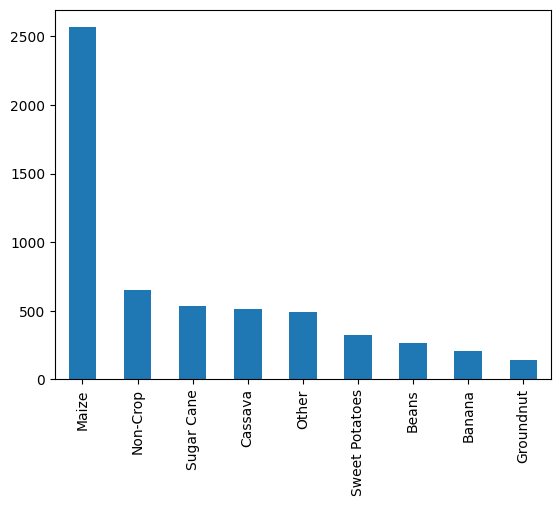

Size of each class:


,crop type,amount,% of all dataset
0,Maize,2568,45.171504
1,Non-Crop,647,11.380827
2,Sugar Cane,533,9.375550
3,Cassava,512,9.006157
4,Other,488,8.583993
5,Sweet Potatoes,325,5.716799
6,Beans,265,4.661390
7,Banana,209,3.676341
8,Groundnut,138,2.427441


In [6]:
class_counts = csv_df_3['cropType'].value_counts()
class_counts.plot.bar()
plt.show()
print('Size of each class:')
class_df = class_counts.rename_axis('crop type').reset_index(name='amount')
class_df['% of all dataset'] = (class_df['amount'] / len(csv_df_3)) * 100
class_df

By plotting the whole dataset by crop type, you can see that there is a big imbalance where the maize class is just under half of the dataset, whereas the other 8 classes are between 11% and 2% of the dataset

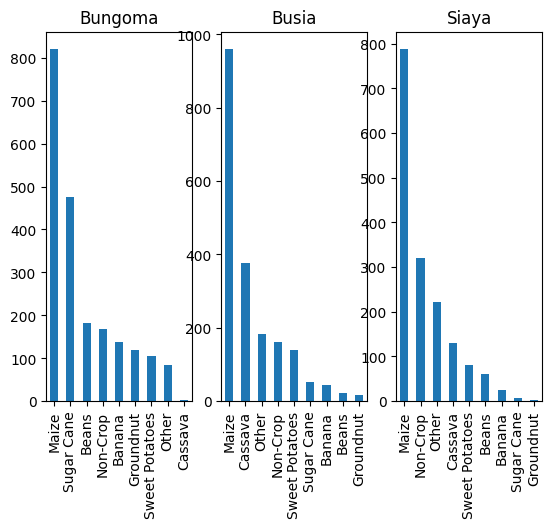

In [7]:
REGIONS = csv_df_3['region'].unique().tolist()
fig, axs = plt.subplots(ncols=3)
for i in range(len(REGIONS)):
    region = REGIONS[i]
    csv_df_3[csv_df_3.region == region]['cropType'].value_counts().plot.bar(ax=axs[i])
    axs[i].title.set_text(REGIONS[i])
plt.show()

You can also see that this maize imbalance is also true when looking by region.

**time series frequency**

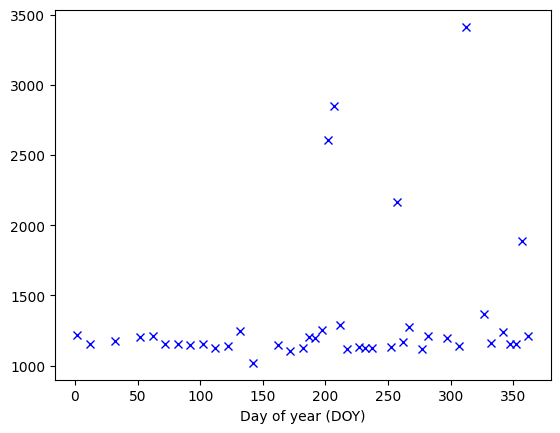

In [8]:
timeseries_filenames = csv_df_3['fileName'].values
timeseries_arrays = []
timeseries_dir = os.path.join(dataset_dir, 'timeseries/')
for filename in timeseries_filenames:
    timeseries_arrays.append(np.load(os.path.join(timeseries_dir, filename), allow_pickle=True))

days = np.arange(365)
plt.plot(days, timeseries_arrays[0][0], 'xb-')
plt.xlabel('Day of year (DOY)')
plt.show()

By just plotting one of the bands of the the first time series in the dataset, you can see that the frequency of points in the timeseries is not constant, for example in the first 50 days there are 3 points, and in the next 50 days there are 5 points.

In [9]:
print('data type: ', type(timeseries_arrays[0][0]))
print('Total number of time series: ', len(timeseries_arrays) * len(timeseries_arrays[0]))

count_missing_data = np.zeros(365, dtype=int)
for timeseries in timeseries_arrays:
    for i in range(len(timeseries)):
        count_missing_data += np.invert(np.ma.getmask(timeseries[i])).astype(int)

unique, counts = np.unique(count_missing_data, return_counts=True)
print('count  :  occurences')
print(np.asarray((unique, counts)).T)


data type:  <class 'numpy.ma.core.MaskedArray'>
Total number of time series:  79590
count  :  occurences
[[    0   319]
 [22834     1]
 [50260     1]
 [79520     1]
 [79534     1]
 [79590    42]]


The data is provided in a [numpy masked array](https://numpy.org/doc/stable/reference/maskedarray.html), so I can verify if the frequency of points in all the timeseries is the same, by counting the the amount of data for each index for all the timeseries. The code above shows that the frequency is not exactly the same for all timeseries, however 42 days are the same day for all of the time series, and further 4 days appear in some timeseries, so the range of days all the timeseries contain is [42,46]

**missing time series metadata**

In [10]:
print('data type: ', type(timeseries_arrays[0]))
print('number of bands: ', timeseries_arrays[0].shape[0])

data type:  <class 'numpy.ma.core.MaskedArray'>
number of bands:  14


As shown above the the time series part of the dataset is provided as numpy masked arrays, which contains no textual information, at least from what I can tell. For each label there are 14 timeseries which correspond to the 13 Sentinel-2 bands and GCVI (greenchlorophyll vegetation index) as an additonal band. However as the timeseries are not provided with any textual information or documentation, at least from what I can tell, I cannot distinguish which timeseries corresponds to which band.

### Does the data need any pre-processing to successfully apply standard machine learning models? If so, what kind? Please do the pre-processing that you consider necessary. (5%)

Having looked looked at the challenges of the dataset in the previous section, this is the pre-processing I believe the dataset needs:
1. Remove 8 data with missing crop type
2. Remove 53 data with unexpected region
3. Encode crop type to numerical values
4. Deal with the frequency of the time series


**Step 1: Remove 8 data with missing crop type**

In [11]:
csv_df = pd.read_csv(os.path.join(dataset_dir, 'crop_type_kenya_2017_metadata.csv'))

original_size = len(csv_df)
csv_df = csv_df.dropna(axis=0)
removed_size = len(csv_df)
print('Size of data before removing missing values: {}, after removal: {}, difference: {}'.format(original_size, removed_size, (original_size - removed_size)))

Size of data before removing missing values: 5746, after removal: 5738, difference: 8


**Step 2: Remove 53 data with unexpected region**

In [12]:
original_size = len(csv_df)
csv_df = csv_df[csv_df.region != 'pilot']
removed_size = len(csv_df)
print('Size of data before removing unexpected values: {}, after removal: {}, difference: {}'.format(original_size, removed_size, (original_size - removed_size)))

Size of data before removing unexpected values: 5738, after removal: 5685, difference: 53


**Step 3: Encode crop type to numerical values**

Standard machine learning models require numerical data, and the labels provided are textual, so I need to encode these to numerical values

In [13]:
CROPS = csv_df['cropType'].unique().tolist()
NUM_CROP_TYPES = len(CROPS)
CROP_LABELS = {}
print('Encoding')
for i, crop in enumerate(CROPS):
    print('{}: {}'.format(crop, i))
    CROP_LABELS[crop] = i

print('example encoded labels')
csv_df['cropLabel'] = csv_df['cropType'].replace(CROP_LABELS)
csv_df.loc[:,['cropLabel', 'cropType']].head()

Encoding
Maize: 0
Sweet Potatoes: 1
Non-Crop: 2
Sugar Cane: 3
Banana: 4
Other: 5
Groundnut: 6
Cassava: 7
Beans: 8
example encoded labels


,cropLabel,cropType
53,0,Maize
54,1,Sweet Potatoes
55,0,Maize
56,2,Non-Crop
57,3,Sugar Cane


**Step 4: Deal with the frequency of the timeseries**

As shown in the previous section, the timeseries do not have data for every day in the year. Some options to address this are:

Option 1 is to fill in the missing days, using a method such as interpolation, however the downside to this would be 1. there are only 42 to 46 days that have data out of the 365 days, 11.5-12.6%, so only 11.5-12.6% of the data would be real world measurements and nearly 90% would be generated. 2. this would increase the training time of the model as it would have to deal with around 9x more data

Option 2 is to take a weekly average and therefore have 52 points. The advantage of this over option 1 is that we are only increasing the dataset by around 1.2x so the training time will not increase as much. The disadvantage is however is

C:\Users\mateu\AppData\Local\Temp\ipykernel_19448\1329688489.py:12: RuntimeWarning: Mean of empty slice.
  example_week_average.append(seven_days[seven_days != 0].mean())
c:\Users\mateu\anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


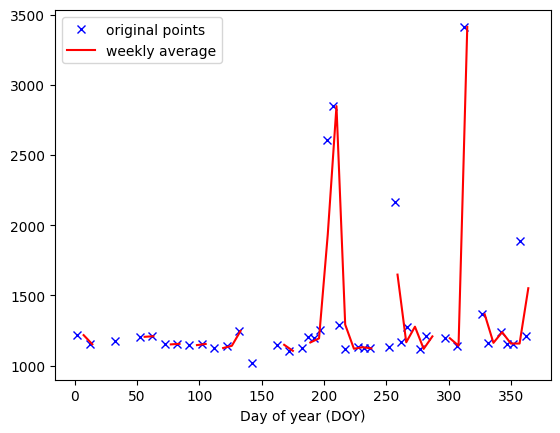

In [15]:
timeseries_filenames = csv_df['fileName'].values
timeseries_arrays = []
timeseries_dir = os.path.join(dataset_dir, 'timeseries/')
for filename in timeseries_filenames:
    timeseries_arrays.append(np.load(os.path.join(timeseries_dir, filename), allow_pickle=True))

# averaging weekly
example = timeseries_arrays[0][0]
example_days = np.array(timeseries_arrays[0][0])
example_week_average = []
for i in range(52):
    seven_days = example_days[(i*7) : ((i+1)*7)]
    example_week_average.append(seven_days[seven_days != 0].mean())

days = np.arange(365)
week_days = np.arange(7, 365, 7)
plt.plot(days, example, 'xb', label='original points')
plt.plot(week_days, example_week_average, c='r', label='weekly average')
plt.legend()
plt.xlabel('Day of year (DOY)')
plt.show()

that as you can see we lose some of the trends in the original data, for example some peaks get flattened as originally in the data there are 1 point spikes but these now get averaged over a week, which may make classification harder. Also, due to the previously mentioned infrequency some weeks would be averaged from more points and in fact some weeks don't even have points so you would have to interpolate some weeks.

Option 3 is drop the missing days of every time series, leaving 46 days with some time series missing 1-4 days, and interpolating these few missing days. This solves the disadvantages of the other 2 options, however it brings its own disadvantage of re-use of the model. In this option the model would be trained to learn how to classify crops on only 46 specific days of the year. Now say in the future you have data for 100 days, or in the future you can only collect data for 30 days, or in the future you can only collect data for 46 other days, the model cannot be re-used directly and, depending on the scenario either would need to be retrained or the data would need to be pre-processed/augmented.

All the options have their disadvantages due to the context of the dataset, because for example if you had 360 days of the 365 days in a year, then option 1 would probably be the best. With the current information I have however, I will choose option 3. The disadvantages of option 1 and 2 will directly affect the model and potential performance now, whereas the disadvantage of option 3 is speculative, something that may happen could affect it's reuse, however I believe it is important to acknowledge this and if this model was to be deployed in the real world then it would be beneficial to first to do some investigation with the data collectors to make a more informed choice on the best amount of days to train the model on. I therefore apply option 3:

In [16]:
# get mask for 46 days
mask_for_max_days = None
max_days = 0
for timeseries in timeseries_arrays:
    if (timeseries[0].compressed().size > max_days):
        max_days = timeseries[0].compressed().size
        mask_for_max_days = np.ma.getmask(timeseries[0])
print('most days in one timeseries: ', max_days)
NUM_DAYS = max_days

# extract the 46 days from each timeseries, where missing values are set as np.nan
old_timeseries_arrays = timeseries_arrays
timeseries_arrays = []
NUM_BANDS = len(old_timeseries_arrays[0])
for timeseries in old_timeseries_arrays:
    new_timeseries_bands = []
    for i in range(NUM_BANDS):
        this_mask = np.ma.getmask(timeseries[i])
        new_timeseries = np.copy(timeseries[i])
        new_timeseries[this_mask == True] = np.nan
        new_timeseries_bands.append(new_timeseries[mask_for_max_days == False])
    timeseries_arrays.append(new_timeseries_bands)
timeseries_arrays = np.array(timeseries_arrays)
print('are there some missing values in some timeseries in the {} days: {}'.format(max_days, np.isnan(timeseries_arrays).any()))

# interpolate where there are missing values in the 46 days
# interpolation code adapted from https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

for timeseries in timeseries_arrays:
    for i in range(NUM_BANDS):
        if np.isnan(timeseries[i]).any():
            nans, array = nan_helper(timeseries[i])
            timeseries[i][nans] = np.interp(array(nans), array(~nans), timeseries[i][~nans])
print('are there some missing values in the {} days after interpolation: {}'.format(max_days, np.isnan(timeseries_arrays).any()))


most days in one timeseries:  46
are there some missing values in some timeseries in the 46 days: True
are there some missing values in the 46 days after interpolation: False


## What are the characteristics of your dataset? Do you see any trends in the data? (5%)

Now that the data is pre-processed I can analyse the characteristics and trends. However as I have mentioned in a previous section, I am not given any information on the bands, so to analyse trends I generically name them as band_0, band_1,..., band_13.

In [17]:
import sktime
from sktime.utils.plotting import plot_correlations
from sktime.datatypes._panel._convert import from_3d_numpy_to_nested
band_names = ['band_' + str(i) for i in range(NUM_BANDS)]
timeseries_df = from_3d_numpy_to_nested(timeseries_arrays, column_names=band_names)

dataset_df = csv_df.copy()
dataset_df = pd.concat([dataset_df, timeseries_df], axis=1)

As the dataset is made of multiple time series, it is hard to analyse trends especially as there are 14 bands, so I have to be creative. A standard trend analysis technique of time series is autocorrelation, which shows the correlation between a time series and a lagged version of the time series. This in turn informs us how much correlation there is between past values and future values.

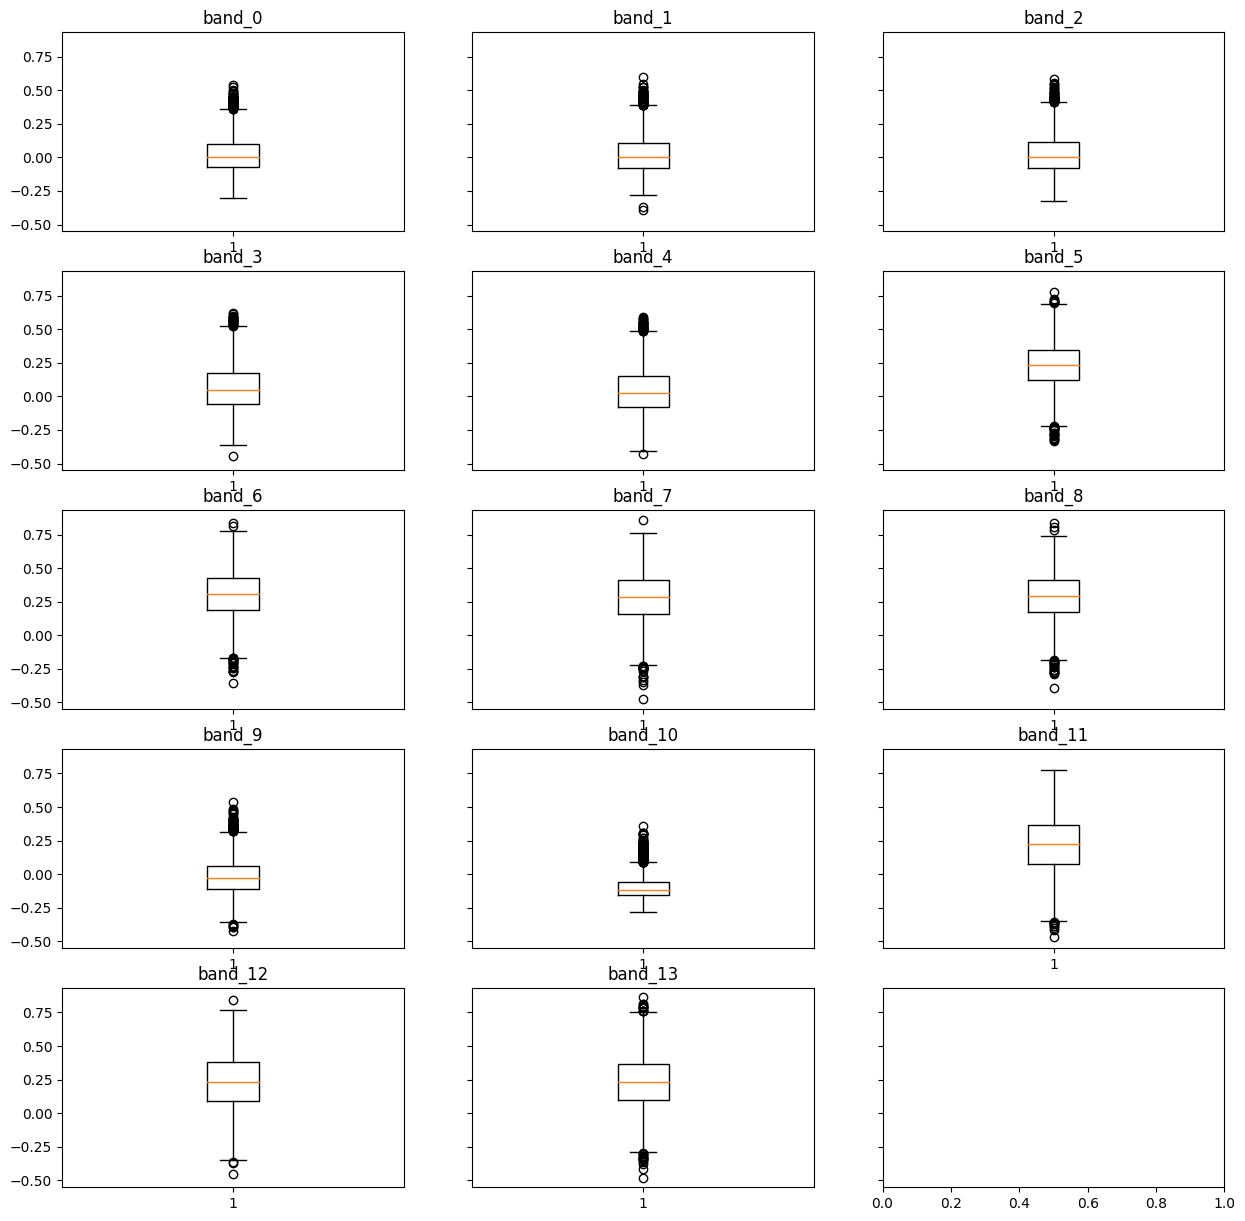

In [18]:
def get_autocorrelation(timeseries):
    return timeseries.autocorr()

autocorrelation_df = timeseries_df.copy()
autocorrelation_df = autocorrelation_df.applymap(get_autocorrelation)

fig, axs = plt.subplots(5, 3, figsize=(15, 15), sharey=True)
for i in range(NUM_BANDS):
    this_band = band_names[i]
    axs[i//3][i%3].boxplot(autocorrelation_df[this_band])
    axs[i//3][i%3].set_title(this_band)

To anlayse autocorrelation for the data set I decide to calculate the autocorrelation for each time series in each band, and then plot the the autocorrelations per band to see whether there is any trends in the respective bands. As you can see above the autocorrelation for most of the bands has a median in the range [-0.25,0.25] and an IQR in the range [-0.5, 0.5], suggesting that there is not strong (postive or negative) autocorrelation for any of the bands. One trend you can see however, is most bands have a wide spread of autocorrelation, whereas band_10 has the smallest spread, suggesting it has the lowest varaince of autocorrelation across the timeseries. I therefore look into this band further to see if there are any trends across the different crops for this band

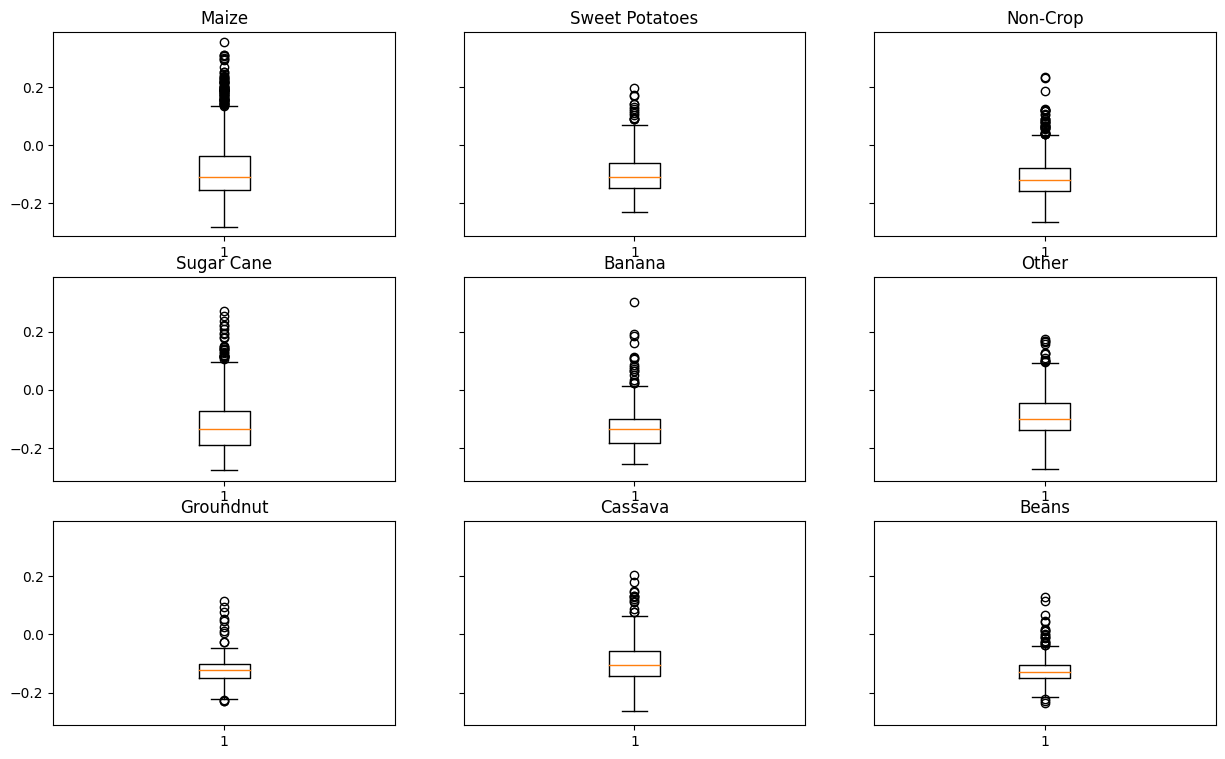

In [19]:
band_10_autocorrelation_df = autocorrelation_df[['band_10']].copy()
labels_df = csv_df[['cropType']].copy()
labels_df.reset_index(drop=True, inplace=True)
band_10_autocorrelation_df = pd.concat([band_10_autocorrelation_df, labels_df], axis=1)

fig, axs = plt.subplots(3, 3, figsize=(15, 9), sharey=True)
band_10_autocorrelation_df.loc[band_10_autocorrelation_df['cropType'] == 'Maize']

for i, this_crop in enumerate(CROPS):
    axs[i//3][i%3].boxplot(band_10_autocorrelation_df.loc[band_10_autocorrelation_df['cropType'] == this_crop]['band_10'])
    axs[i//3][i%3].set_title(this_crop)

Again we see there is no strong autocorrelation for any of the crop types, however you can see that maize has the biggest spread, and the most 'outliers', which could be due to the fact that, as I discovered in the first section, there is a class imbalance for maize and there is the most amount of data for it.

Another thing that I can analyse is the mean value of the time series.

In [20]:
def get_mean(timeseries):
    return timeseries.mean()

mean_df = timeseries_df.copy()
mean_df = mean_df.applymap(get_mean)
mean_df.mean()

band_0     1385.453520
band_1     1178.401637
band_2     1169.526446
band_3     1098.839585
band_4     1400.398543
band_5     2461.149912
band_6     2909.644442
band_7     2788.070514
band_8     3170.280077
band_9      773.120642
band_10      35.191849
band_11    2400.952342
band_12    1468.583452
band_13       1.525098
dtype: float64

As you can see, when looking at the mean values per band, by far the lowest absolute value is band_13 and band_8 is the highest.

I will also look at the mean value across all bands for each crop type, to see if there are any trends when the timeseries are just reduced to the mean value of all bands

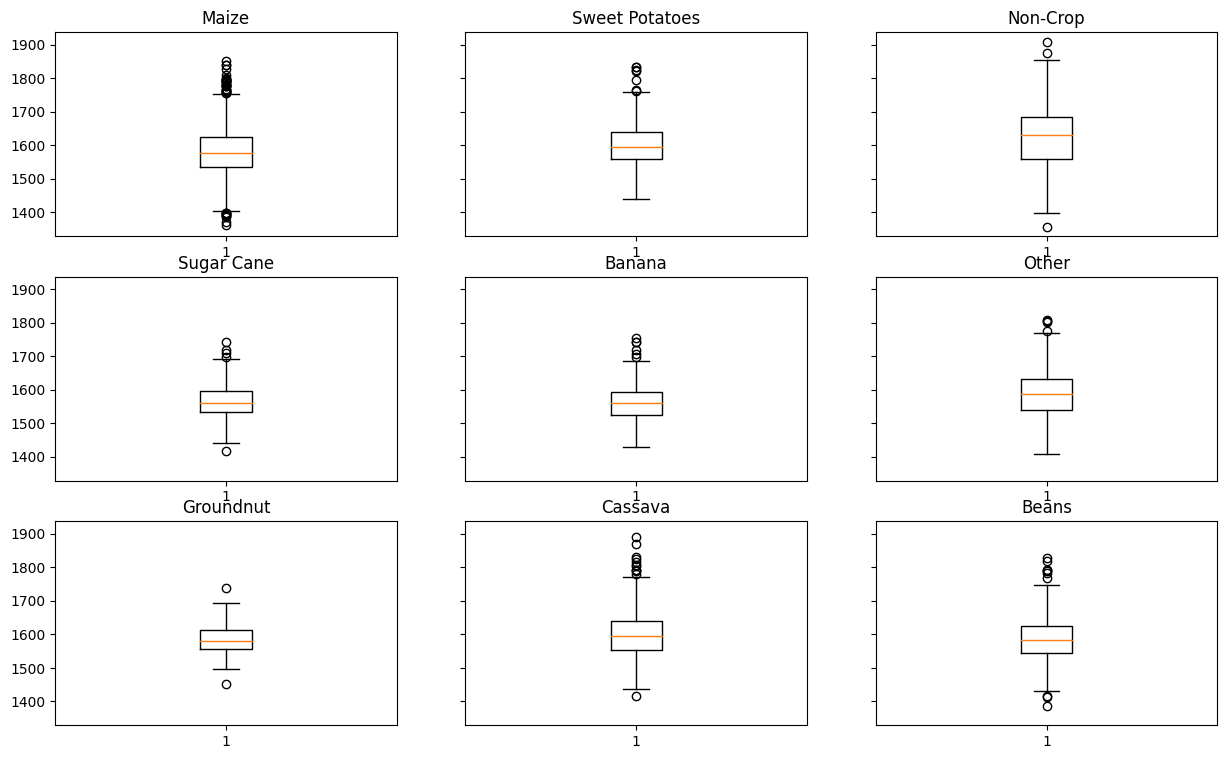

In [21]:
mean_df['mean'] = mean_df.mean(axis=1)
mean_df = pd.concat([mean_df, labels_df], axis=1)

fig, axs = plt.subplots(3, 3, figsize=(15, 9), sharey=True)
for i, this_crop in enumerate(CROPS):
    axs[i//3][i%3].boxplot(mean_df.loc[mean_df['cropType'] == this_crop]['mean'])
    axs[i//3][i%3].set_title(this_crop)

Unfortunately there is not much of a trend, however for non-crop it is interesting to see that the spread is very wide, which makes sense as the non-crop class encapsulates everything else apart from the other 8 crops, which may make it hard to classify as this class has such a variety of values.

Importantly however, from both mean analyses, you can see that the absolute values of the data in the timeseries get very large, while for band_13 for example the mean is 1.5. This indicates I also need to add scaling of the values to the pre-processing, because this will cause problems for the ML models. I will use [sklearn StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) as, as shown by the distributions of values in the box plots, there are many 'outliers' and just scaling the values between 0 and 1 would not represent the distributions in the bands well.

In [22]:
from sklearn.preprocessing import StandardScaler

# scale per band
for i in range(NUM_BANDS):
    this_scaler = StandardScaler()
    timeseries_arrays[:,i,:] = this_scaler.fit_transform(timeseries_arrays[:,i,:])

## Task and evaluation (10%)

### Main task for dataset

As explored in the SustainBench paper [3], it is important to asses agricultural diversity and estimate yields, as it could improve food security, and having information of crop types enables this. Currently for high income countries departments of agriculture produce crop type maps annually using farm surveys and satellite imagery [4]. But for middle/low-income countries these are not regularly available, especially in the global south where there are challenges such as *"irregularly shaped fields, small fields, intercropping, sparse ground truth labels, and highly heterogeneous landscapes"*[5]. 

As can be seen by the previous sections and the above, the task that naturally comes from this dataset is a **multivariate multi-class classification task, where the aim is to classify crop types**. The dataset is for a global south lower-middle income country (Kenya which in 2021 has a GDP per capita of 2006.8 compared to the 2581.0 lower middle income value provided by the world bank [6]) and if the task is successful then it could be used to provide crop maps for these types countries. Therefore solving the problem presented above.

### Evaluation criteria

I will use 2 types of evaluation criteria:

**Accuracy** - As this is a classification task, the standard evaluation is the accuracy. This simply tells us how accurately the given model predicts the classes for a given set of predictions, and is defined as the ratio of correct prediction to total predictions:

$$ \text{accuracy} = \frac{\text{\# of correct predictions}}{\text{\# of total predictions}}$$

Accuracy is useful as it shows how accurate the model is, however in the case of this dataset where there is an imbalance in classes, the accuracy can be misleading. As explored above the biggest class accounts for 45% of the data, so if a model just always predicted this class it would still have an accuracy of 45%. Therefore, other metrics are needed to account for this class imbalance. For multi-class classification, one of these is macro f1 score.

**Macro f1 score** - As explained above, there is flaw in accuracy for imbalanced classification, and it comes from the fact it only looks at correct predictions. A common type of metric that instead also takes into account incorrect predictions, therefore accounting for the imbalance by penalising for incorrect predictions of a class, is f1 score. It is a metric defined per class as: 

$$ \text{f1 score} = \frac{\text{true positives}}{\text{true positives} + \frac{1}{2} \times (\text{false positives} + \text{false negatives})}$$

Now to get a metric which covers all the classes in the task (as this is a multi-class classification task), I need to aggregate all the f1 scores for each class. One way to do this is called macro f1 score, which is an unweighted mean of the f1 scores per class, defined as:
 
$$ \text{macro f1 score} = \frac{\text{sum of f1 scores per class}}{\text{number of classes}}$$

Unlike with accuracy, macro f1 score penalises for incorrect predictions, so if a model just predicts the biggest class it will get a low score.

**Multi-class confusion matrix** - Another way to get a deeper insight into misclassification is by using a confusion matrix, in this case a multi-class confusion matrix. This will allow me to further investigate and visually display how often the given model is predicting which class correctly/incorrectly.

## Design and build an ML system (20%)

### Splitting data into train and test sets

It is a common standard in ML to split a dataset into two sets, a train set to train the model on and a test set to test the model on and calculate evaluation metrics. As explained in the first section, the SustainBench authors provide a random split which I use:

In [23]:
split_idx = {
    'x_train': 0,
    'y_train': 1,
    'x_test': 2,
    'y_test': 3
}
def get_split_dataset():
    split_type = 'fold_random'

    print('x (timeseries) shape before split: ', timeseries_arrays.shape)
    print('y (labels) shape before split: ', csv_df[['cropLabel']].shape)

    train_mask = csv_df[split_type] == 'train'
    test_mask = csv_df[split_type] == 'test'

    x_train = timeseries_arrays[train_mask]
    y_train = csv_df[train_mask][['cropLabel']].to_numpy().flatten()
    print('train shapes after split, x: {}, y: {}'.format(x_train.shape, y_train.shape))

    x_test = timeseries_arrays[test_mask]
    y_test = csv_df[test_mask][['cropLabel']].to_numpy().flatten()
    print('test shapes after split, x: {}, y: {}'.format(x_test.shape, y_test.shape))
    print('')
    print('split ratio (train:test) {}:{}'.format(((y_train.size/len(csv_df))*100), ((y_test.size/len(csv_df))*100)))
    
    return x_train, y_train, x_test, y_test

dataset = get_split_dataset()

x (timeseries) shape before split:  (5685, 14, 46)
y (labels) shape before split:  (5685, 1)
train shapes after split, x: (4551, 14, 46), y: (4551,)
test shapes after split, x: (1134, 14, 46), y: (1134,)

split ratio (train:test) 80.05277044854881:19.947229551451187


### Model selection

As mentioned in the first section, according to the SustainBench authors, to their knowledge, deep-learning based methods such as CNNs have not yet been tested on this dataset. Due to this I will explore different deep-learning approaches, along with random forest approaches (as the baseline is this approach).

A big challenge of this dataset is the structure of the data. As seen in previous sections it consists of multiple time series (consisting of multiple days) for each label. One aspect is the curse of dimensionality (there is a lot of input data for each output), another is the shape of the input data and lastly another is the temporal aspect of the data (as the inputs are time series). The previous studies [1][2] mainly focus on the curse of dimensionality, I with deep-learning approaches will focus more on addressing the shape and temporal aspect of the data. Therefore, the aspects that influence my model selection are:

- There are different ways I can deal with the shape of the data. The choice of how, will also influence what model I can use. The ways I have identified are: **(1):** One of the most simple ways would be to concatenate all the bands together into one time series so that the task is augmented from a multivariate time series classification task to just a time series classification task. **(2):** Another way would be to train a model per each band and then combine the classifications from each into one final classification, a form of ensemble method. **(3):** Lastly I could leave the shape of the data as is.

- As mentioned, there is also the temporal aspect of the data. In ML **(4)**: recurrent neural networks (RNNs) are models commonly used for temporal data as they are made of recurrent cells. These cells states are affected by both past states and current input with feedback connections, which allows RNNs to learn over time intervals [7].

- Lastly, the baseline study [1] only achieved a macro f1 score of 0.30, which is low. This suggests that it maybe be hard to achieve good performance with this dataset. While deep-learning methods, as the SustainBench authors mention, should perform better, it is not guaranteed. Therefore, another aspect of model selection I take into consideration is uncertainty estimation. Even if my proposed models don't perform well for all classifications, having associated uncertainty with a classification will mean the model can express it is uncertain on a classification and a threshold could be used to allow the model to express a "I don't know" classification. There are multiple approaches to uncertainty estimation such as single network deterministic methods, Bayesian methods, ensemble methods and test-time augmentation methods [9]. As (2) is already a form of ensemble methods, one approach I will take for uncertainty estimation is **(5):** ensemble method. For variety, and due the fact that ensemble methods are computationally expensive as they require you to train multiple models, another approach I decide to take for uncertainty estimation is **(6):** variational inference (VI), which can be implemented fairly efficiently by using Bayes by Backprop [9]

The above aspects therefore led me to selecting these models:

1) **random forest (baseline)** - Although the baseline study [1] does not provide the code for their exact model, I decide to use their model type, by using (1), to build my own baseline.
2) **ensemble random forest** - I chose this model to explore (2), but also to build on the baseline by adding uncertainty estimation through (5)
3) **ensemble RNN** - I chose this model to explore (4), and as RNN's are not as computationally expensive as for example CNN's, I estimate uncertainty using (5), which also means this model is making use of (2)
4) **Bayesian CNN (BCNN)** - I chose this model to explore (3), and as CNNs can be computationally expensive, to estimate uncertainty I use (6)

For implementation, for the random forests I use the [TimeSeriesForestClassifier from sktime](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.classification.interval_based.TimeSeriesForestClassifier.html), for the RNN I use [LSTM and Dense layers from keras](https://www.tensorflow.org/api_docs/python/tf/keras/layers) and for the BCNN I use a python library to build BCNNs that can be found [here](https://github.com/kumar-shridhar/PyTorch-BayesianCNN).

To implement the ensemble part of the ensemble models, I take a simple approach in which I train 14 models, 1 for each band, and then to make a classification I make a classification using each model, where the final classification is the mode of the 14 classifications, and the associated uncertainty is 1 minus the number of models that classified that label divided by the total number of models (14). So say the 14 classifications from the ensemble were [1,1,1,1,1,1,1,1,1,1,1,1,1,2], the final classification would be 1 and the uncertainty 1-(13/14)=0.07


In [24]:
# defining random forest
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.pipeline import Pipeline
from sktime.transformations.panel.compose import ColumnConcatenator

random_forest_pipeline = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(random_state=1)),
]

In [25]:
# defining ensemble random forest 
ensemble_random_forest = []
for x in range(NUM_BANDS):
    ensemble_random_forest.append(TimeSeriesForestClassifier(random_state=1))

In [26]:
# defining RNN for ensemble RNN
from keras.models import Sequential
import keras.layers as layers
from keras.utils import to_categorical

def BuildRNN():
    model = Sequential()
    model.add(layers.LSTM(100, input_shape=(1,46)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(NUM_CROP_TYPES, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
# defining BCNN
sys.path.append("PyTorch_BayesianCNN/") # BCNN python library from https://github.com/kumar-shridhar/PyTorch-BayesianCNN
from PyTorch_BayesianCNN.layers import ModuleWrapper, FlattenLayer, BBB_Linear, BBB_Conv2d

class BCNN(ModuleWrapper):
    def __init__(self, outputs, priors):
        super(BCNN, self).__init__()

        self.num_classes = outputs
        self.priors = priors
        self.activation = torch.nn.ReLU

        self.conv1 = BBB_Conv2d(1, 1, 5, padding='same', bias=True, priors=self.priors)
        self.act1 = self.activation()
        self.pool1 = torch.nn.MaxPool2d(2)

        units = int((NUM_BANDS/2) * (NUM_DAYS/2))
        self.flatten = FlattenLayer(units)
        self.fc1 = BBB_Linear(units, 200, bias=True, priors=self.priors)
        self.act2 = self.activation()

        self.fc2 = BBB_Linear(200, 100, bias=True, priors=self.priors)
        self.act3 = self.activation()

        self.fc3 = BBB_Linear(100, outputs, bias=True, priors=self.priors)

In [28]:
import dill

def load_model(path):
    with open(path, 'rb') as f:
        model = dill.load(f)
    return model

def save_model(model, path):
    with open(path, 'wb') as f:
        dill.dump(model, f)

# code so keras models can be pickled and saved from https://stackoverflow.com/a/71998332
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils

def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

    # Hotfix function
def make_keras_picklable():

    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))

    cls = Model
    cls.__reduce__ = __reduce__
make_keras_picklable()

In [29]:
import os
from sklearn.metrics import f1_score, accuracy_score
models_dir = './../../../../../Desktop/models/'

from PyTorch_BayesianCNN.main_bayesian import *
from PyTorch_BayesianCNN.data.data import CustomDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import Adam
from PyTorch_BayesianCNN.metrics import ELBO
import statistics as st
from scipy import stats

def get_band_x(band, x_in):
            x_out = x_in[:,band,:]
            return x_out.reshape(x_in.shape[0], x_in.shape[2])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def train_model_type(type, epochs = 50):
    train_loss = []
    test_accuracy = None
    macro_f1 = None
    preds = []
    uncertainties = []
    models = []
    model_path = models_dir + type + '.pkl'

    if type == 'random_forest':
        # if model already trained load it, else train and save
        if os.path.exists(model_path):
            model = load_model(model_path)
        else:
            model = Pipeline(random_forest_pipeline)
            model.fit(dataset[split_idx['x_train']], dataset[split_idx['y_train']])
            save_model(model, model_path)

        # predict
        preds = model.predict(dataset[split_idx['x_test']])

        # evaluate predictions
        test_accuracy = accuracy_score(dataset[split_idx['y_test']], preds)
        macro_f1 = f1_score(dataset[split_idx['y_test']], preds, average='macro')

    if type == 'ensemble_random_forest':
        # if models already trained load it, else train and save
        if os.path.exists(model_path):
            models = load_model(model_path)
        else:
            models = ensemble_random_forest
            for band, model in enumerate(models):
                x_train = get_band_x(band, dataset[split_idx['x_train']])
                model.fit(x_train, dataset[split_idx['y_train']])
            save_model(models, model_path)

        # predict
        ensemble_preds = []
        for band, model in enumerate(models):
            x_test = get_band_x(band, dataset[split_idx['x_test']])
            ensemble_preds.append(model.predict(x_test))
        ensemble_preds = np.array(ensemble_preds)
        preds = stats.mode(ensemble_preds, keepdims=True).mode[0]
        uncertainties = 1 - ((ensemble_preds == np.tile(preds, (NUM_BANDS,1))).sum(axis=0) / NUM_BANDS)

        # evaluate predictions
        test_accuracy = accuracy_score(dataset[split_idx['y_test']], preds)
        macro_f1 = f1_score(dataset[split_idx['y_test']], preds, average='macro')

    elif type == 'ensemble_rnn':
        # prepare data
        y_train = to_categorical(dataset[split_idx['y_train']], num_classes=NUM_CROP_TYPES)

        # if models already trained load it, else train and save
        if os.path.exists(model_path):
            models = load_model(model_path)
        else:
            models = []
            for band in range(NUM_BANDS):
                x_train = get_band_x(band, dataset[split_idx['x_train']]).reshape(-1, 1, NUM_DAYS)
                model= BuildRNN()
                model.fit(x_train, y_train, epochs=epochs, verbose=0)
                models.append(model)
            save_model(models, model_path)

        # predict
        ensemble_preds = []
        y_test = to_categorical(dataset[split_idx['y_test']], num_classes=NUM_CROP_TYPES)
        for band, model in enumerate(models):
            x_test = get_band_x(band, dataset[split_idx['x_test']]).reshape(-1, 1, NUM_DAYS)
            outputs = model.predict(x_test, verbose=0)
            ensemble_preds.append([np.argmax(output, axis=None, out=None) for output in outputs])
        ensemble_preds = np.array(ensemble_preds)
        preds = stats.mode(ensemble_preds, keepdims=True).mode[0]
        uncertainties = 1 - ((ensemble_preds == np.tile(preds, (NUM_BANDS,1))).sum(axis=0) / NUM_BANDS)

        # evaluate predictions
        test_accuracy = accuracy_score(dataset[split_idx['y_test']], preds)
        macro_f1 = f1_score(dataset[split_idx['y_test']], preds, average='macro')

    elif type == 'bcnn':
        # prepare data
        train_size = len(dataset[split_idx['x_train']])
        indices = list(range(train_size))
        np.random.shuffle(indices)
        train_sampler = SubsetRandomSampler(indices)
        x_train = np.float32(dataset[split_idx['x_train']])
        x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
        trainset = CustomDataset(x_train, dataset[split_idx['y_train']])
        batch_size = 512
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)

        model = BCNN(NUM_CROP_TYPES, cfg.priors).to(device)
        criterion = ELBO(train_size).to(device)
        optimizer = Adam(model.parameters())

        # if model already trained load it, else train and save
        if os.path.exists(model_path):
            model = load_model(model_path)
        else:
            for epoch in range(epochs):
                loss, train_acc, _ = train_model(model, optimizer, criterion, train_loader)
                train_loss.append(loss)
            save_model(model, model_path)

        # predict
        x_test = np.float32(dataset[split_idx['x_test']])
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])
        testset = CustomDataset(x_test, dataset[split_idx['y_test']])
        test_loader = torch.utils.data.DataLoader(testset, batch_size=len(x_test))
        input, _ = next(iter(test_loader))
        input = input.to(device)

        K = 100
        k_preds = []
        for _ in range(K):
            model_out, _ = model(input)
            outputs = torch.zeros(len(input), model.num_classes, 1).to(device)
            outputs[:, :, 0] = F.log_softmax(model_out, dim=1).data
            log_outputs = utils.logmeanexp(outputs, dim=2)
            this_preds = log_outputs.cpu().numpy().argmax(axis=1)
            k_preds.append(log_outputs.cpu().numpy().argmax(axis=1))
        k_preds = np.array(k_preds)
        preds = stats.mode(k_preds, keepdims=True).mode[0]
        uncertainties = 1 - ((k_preds == np.tile(preds, (K,1))).sum(axis=0) / K)

        # evaluate predictions
        test_accuracy = accuracy_score(dataset[split_idx['y_test']], preds)
        macro_f1 = f1_score(dataset[split_idx['y_test']], preds, average='macro')
        models = [model]
    
    return train_loss, test_accuracy, macro_f1, preds, uncertainties, models

LOSS = 0
ACC = 1
F1 = 2
PREDS = 3
UNCS = 4
MODELS = 5

## Experimental analysis (performance & scalability) (20%)

I train all the models using the train set, and then test the models using the test set below:

In [30]:
def print_stats(model_stats):
    print('Accuracy: ', model_stats[ACC])
    print('Macro F1: ', model_stats[F1])

In [31]:
random_forest_stats = train_model_type('random_forest')
print_stats(random_forest_stats)

Accuracy:  0.5987654320987654
Macro F1:  0.3134314749203647


In [32]:
ensemble_random_forest_stats = train_model_type('ensemble_random_forest')
print_stats(ensemble_random_forest_stats)

Accuracy:  0.5282186948853616
Macro F1:  0.19260761185133787


In [64]:
ensemble_rnn_stats = train_model_type('ensemble_rnn', epochs=50)
print_stats(ensemble_rnn_stats)

Accuracy:  0.6261022927689595
Macro F1:  0.40237741225080287


In [63]:
bcnn_stats = train_model_type('bcnn', epochs=5000)
print_stats(bcnn_stats)

Accuracy:  0.6384479717813051
Macro F1:  0.40433189596992913


In [65]:
all_stats = [random_forest_stats, ensemble_random_forest_stats, ensemble_rnn_stats, bcnn_stats]

performance = pd.DataFrame.from_dict({"Accuracy": [model_stats[ACC] for model_stats in all_stats],
                                     "Macro F1":   [model_stats[F1] for model_stats in all_stats]
})

performance.index= ["Random Forest (Baseline)","Ensemble Random Forest","Ensemble RNN","BCNN"]
performance

,Accuracy,Macro F1
Random Forest (Baseline),0.598765,0.313431
Ensemble Random Forest,0.528219,0.192608
Ensemble RNN,0.626102,0.402377
BCNN,0.638448,0.404332


Important to note that for comparisons reasons, I try to keep all aspects of training the models equal. Therefore I:
- use the exact same train test split of the dataset for each model
- due to time constraints, I could not perform hyperparameter tuning, therefore I leave all hyperparameter values as their default values in the packages that I use for implementation. The only hyperparameters I set (as these need to be defined to run the models) are, the layer sizes and epochs for the neural networks (the ensemble RNN and BCNN). I set these values arbitrarily based on past personal experience with neural networks.

### Models performance
The performance table above summarises all the models performances. As you can see interestingly, the random forest approach performs similarly in this in-domain classification as it did in the baseline study [1] in out-of-domain, with the study achieving a macro f1 of 0.30 and mine 0.31. This suggests that the random forest approach, at least without hyperparameter optimisation and different data pre-processing (as I implement my own data pre-processing), performs similarly in out-of-domain and in-domain. 

Underwhelmingly the ensemble approach to random forest performs worse than the baseline, both in accuracy and macro f1, I will further explore the ensemble approach below in experiment 1.

Positively however, even without hyperparameter optimisation and with just a simple network structure that I arbitrarily chose, both deep-learning approaches perform better than the baseline which confirms the SustainBench authors expectation that deep-learning approaches will perform better in in-domain classification. However, the ensemble RNN approach accuracy only improves on the baseline by ~3%, and the BCNN ~4%. What is encouraging however, is the deep-learning approaches seem to deal with class imbalance better than the baseline, both achieving a macro f1 score of 0.4 compared to the baseline of 0.31.

Unfortunately, no model achieves 90%+ accuracy, and I will talk about this more later in the "Further room for improvement" section, however I did mention better performance is not guaranteed by deep-learning methods for this dataset, and planned accordingly by incorporating uncertainty estimation in an attempt to still make these models useful. Below in experiment 2, I therefore explore how the metrics change at different uncertainty thresholds.

### Experiment 1
As mentioned, the ensemble method for random forest performs worse than the baseline, and the ensemble method for the RNN only performs marginally better on accuracy than the baseline. A positive of having one model for each band, is now I can analyse the metrics per band. This gives some insight into which bands are hard to classify by my approaches, and which seem to be the easiest to classify.

In [66]:
from IPython.core.display import HTML
# code to display dataframes side by side from https://stackoverflow.com/a/57832026
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

def get_bands_stats(type, models):
    bands_accuracy = []
    bands_f1 = []
    for band, model in enumerate(models):
        if type == 'random_forest':
            x_test = get_band_x(band, dataset[split_idx['x_test']])
            preds = model.predict(x_test)
        elif type == 'rnn':
            x_test = get_band_x(band, dataset[split_idx['x_test']]).reshape(-1, 1, NUM_DAYS)
            outputs = model.predict(x_test, verbose=0)
            preds = [np.argmax(output, axis=None, out=None) for output in outputs]
        
        bands_accuracy.append(accuracy_score(dataset[split_idx['y_test']], preds))
        bands_f1.append(f1_score(dataset[split_idx['y_test']], preds, average='macro'))
    
    bands_stats = pd.DataFrame.from_dict({"Accuracy": bands_accuracy,
                                        "Macro F1":   bands_f1
    })
    bands_stats.index= band_names
    return bands_stats

df_random_forest_bands = get_bands_stats('random_forest', ensemble_random_forest_stats[MODELS])
df_rnn_bands = get_bands_stats('rnn', ensemble_rnn_stats[MODELS])
display_side_by_side([df_random_forest_bands, df_rnn_bands], ['From ensemble random forest', 'From ensemble RNN'])

,Accuracy,Macro F1
band_0,0.444444,0.181193
band_1,0.552910,0.248973
band_2,0.549383,0.254476
band_3,0.573192,0.251886
band_4,0.514991,0.203389
band_5,0.544092,0.226951
band_6,0.548501,0.221203
band_7,0.576720,0.266322
band_8,0.544974,0.207911
band_9,0.456790,0.182002


As you can see from the tables above, both methods agree that the bands hardest to classify are band_0, band_9 and band_10, as these have the worst accuracy, whereas bands band_3, band_7 and band_13 have the highest accuracy. I will mention the importance of this later in the "Further room for improvement" section.

### Experiment 2


In [72]:
def get_threshold_stats_at(threshold, uncertainties, preds):
    # get only predictions with less uncertainty than threshold
    over_idx = uncertainties < threshold
    above_preds = preds[over_idx]
    percentage = (len(above_preds) / len(preds)) * 100

    # evaluate predictions
    labels_to_evaluate = dataset[split_idx['y_test']][over_idx]
    test_accuracy = accuracy_score(labels_to_evaluate, above_preds)
    macro_f1 = f1_score(labels_to_evaluate, above_preds, average='macro')

    return test_accuracy, macro_f1, percentage

def get_all_thresholds_stats(uncertainties, preds):
    thresholds = [i/10 for i in range(1,11,1)]
    thresholds_accuracy = []
    thresholds_f1 = []
    thresholds_percentage = []
    for threshold in thresholds:
        stats_at = get_threshold_stats_at(threshold, uncertainties, preds)
        thresholds_accuracy.append(stats_at[0])
        thresholds_f1.append(stats_at[1])
        thresholds_percentage.append(stats_at[2])

    thresholds_stats = pd.DataFrame.from_dict({"Accuracy": thresholds_accuracy,
                                        "Macro F1":   thresholds_f1,
                                        "Data % predicted": thresholds_percentage
    })
    thresholds_stats.index= [str(int(i*100)) + "%" for i in thresholds]

    return thresholds_stats

df_ensemble_random_forest_thresholds = get_all_thresholds_stats(ensemble_random_forest_stats[UNCS], ensemble_random_forest_stats[PREDS])
df_ensemble_rnn_thresholds = get_all_thresholds_stats(ensemble_rnn_stats[UNCS], ensemble_rnn_stats[PREDS])
df_bcnn_thresholds = get_all_thresholds_stats(bcnn_stats[UNCS], bcnn_stats[PREDS])
display_side_by_side([df_ensemble_random_forest_thresholds, df_ensemble_rnn_thresholds, df_bcnn_thresholds], ['From ensemble random forest', 'From ensemble RNN', 'From BCNN'])


,Accuracy,Macro F1,Data % predicted
10%,0.702703,0.139096,52.204586
20%,0.673529,0.141426,59.964727
30%,0.608400,0.169864,77.689594
40%,0.584388,0.172088,83.597884
50%,0.569892,0.199506,90.211640
60%,0.532444,0.194971,99.206349
70%,0.529620,0.193588,99.735450
80%,0.528219,0.192608,100.000000
90%,0.528219,0.192608,100.000000
100%,0.528219,0.192608,100.000000


As you can see in the tables, as expected, the lower you set the uncertainty threshold at for the models the higher accuracy you can achieve. The tradeoff is however, you only make classifications for part of the data set. For example, if you only allow 10% uncertainty for the BCNN, you can achieve an accuracy of 80% but you only classify 53% of the data. This tradeoff would have to be considered if you were to set a threshold, so that you can still make classifications and not constantly just say "I don't know". Looking at the tables, an argument could be made for the BCNN at a 40% threshold, where you can increase the accuracy to 70% and the macro f1 to 0.41 while still classifying 81% of the time.

### Further room for improvement
As can be seen by the performance and experiments, this task with this dataset is challenging. However, even without further optimisations of the models, I demonstrate that it is possible to achieve improved accuracy with deep-learning, which is better than the baseline or than just predicting the biggest class (which as discussed in the metrics section would result in about 45% accuracy). Therefore, I believe there is potential to achieve good results with deep-learning for this task and dataset, but it would require more work. These are some of the ideas I have identified through my work with this dataset that may give better results and could be interesting future work (and in fact a combination of these could give the best results):

- **hyperparameter optimisation** - as mentioned I perform no hyperparameter optimisation for any of the models, although I have no evidence this will definitely give better performance for this dataset, it is common practice in ML and usually does improve performance
- **deeper/modified network architectures** - I used pretty simple network architectures; it would be interesting to see whether deeper or more complex architectures would improve performance. The downside to this approach is that it would be more computationally expensive, however in the context of deep-learning this dataset is small so training this kind of architecture should not take really long regardless
- **feature selection** - as mentioned in an earlier section, studies [1][2] mainly focus on feature selection, whereas I focus on deep-learning. It would be interesting to see the performance of the combination of these approaches. Experiment 1 sort of acts as preliminary work for this, in which I show that across two different approaches there is agreement in which bands on their own give the best performance. Interesting future work would be further analysis into which bands or combinations of bands give the best performance, and then feeding only these bands in into one of my deep-learning approaches, which already perform better than the baseline (while using all the bands)
- **different ensemble approach** - I take a very naive ensemble approach (a model per band), which for the random forest performs worse than the baseline, but for the RNN performs better. It would be interesting to see the performance of a more advanced ensemble approach such as a stacking, bagging and boosting. However, the downside, similar to deeper/modified network architectures, is these approaches are more computational expensive.

### How does the model's performance compare to a more/less computationally heavy model?
The least computationally expensive model in my comparison is the baseline, and most is the BCNN. In terms of absolute time to train on my machine however, there is not significant difference, the baseline takes 4 minutes while the BCNN takes 10 minutes, due to the fact that in the context of deep-learning this dataset it small. However, as demonstrated, the BCNN does have better performance (albeit not that much better without further work/optimisation). As this is not a real-time model, and only needs to be trained once, I believe the higher upfront computation could be worth the performance an optimised BCNN could give.

### Is the model scalable to a real-world application? Is the performance is enough for the application that you are aiming to address?
In its current state I believe due to the lack of performance the BCNN is not scalable to real-world application. However, if performance can be improved further, potentially through the future work I suggest, and with the combination of uncertainty thresholds I demonstrate, I believe it is scalable. As mentioned, the training currently takes minutes, and then the predictions are fast. Even if with optimisation it can achieve say only an accuracy of 90%, and with a given uncertainty threshold it can achieve 99% accuracy for 90% of data, I believe this performance is enough for the application that I am aiming to address. The application is not safety critical or medical, so 1 misclassification in 100 does not have the same ramifications as say classifying if a patient has cancer. But in contrast, having a 99% accurate crop map covering 90% of a middle/low-income country (which currently do not have regular crop maps) would be very beneficial to assessing agricultural diversity and estimate yields.

## Ethical considerations (15%)

While inherently the application and dataset aim to do good and improve agriculture in middle/low-income countries, there are 3 ethical dimensions that I believe are important to mention: fairness, interpretability, and data imbalance effects.

### Fairness
While the dataset is made publicly available, as I have mentioned in previously, the data loaders provided with it by SustainBench don't work out of the box. Furthermore, as I show in the "exploratory data analysis" section, there are problems with the data set in its original format. Also, the code for studies [1] and [2] are not made publicly available. All of these aspects have ethical implications, in particular an issue of fairness. People with better education/technological skill have an unfair advantage to be able to use this dataset and application, as they can overcome the issues mentioned unlike others. This is an issue of accessibility and it could cause increased power/wealth concertation as more technologically advanced agriculture actors could make use of this dataset/application while others would be disadvantaged. To address this the dataset (and its associated tools) and applications should be made publicly and easily accessible, with thorough documentation.

### Interpretability
While the task itself is pretty simple to understand, classify a crop based on some satellite bands, I use neural networks to address it, which have a growing concern of their black-box nature which affect people's trust of them [10]. Unfortunately, this is inherent with the approach of deep learning. Given that the aim for the application is that it is used by government/policy makers to improve agriculture and therefore food security, it is imperative that the model can be trusted. One way in which I have tried to address this trust issue is through uncertainty estimation. A classification with an uncertainty should naturally feel more trustworthy to non-technical individuals as, with uncertainty a classification doesn't seem like it has been just made up from this black-box, but instead reasoned about in a way where they network can express how confident it is in it's output. Another way that this could be addressed would be to use a causal modelling approach instead, in which interpretability is a strong advantage, however the performance of this approach would need to be assessed too, because having an interpretable but badly performing model is not useful to anyone.

### Data imbalance effects
As I show in the "exploratory data analysis" section, there is a big imbalance in the amount of maize data there is compared to the other crop types. This could lead to models having a bias to classifying most inputs as maize, and therefore having a more accurate classification for maize compared to the other crop. I explore this below using multi-class confusion matrices

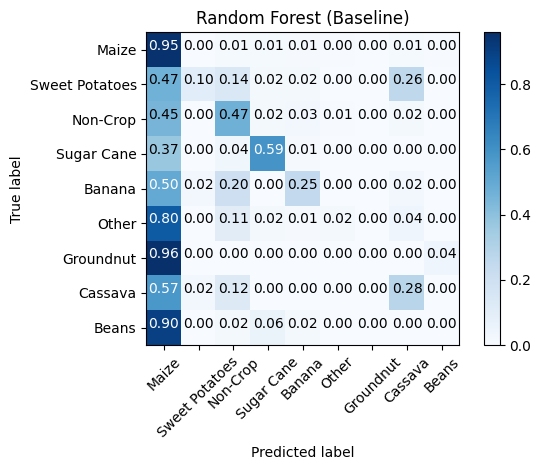

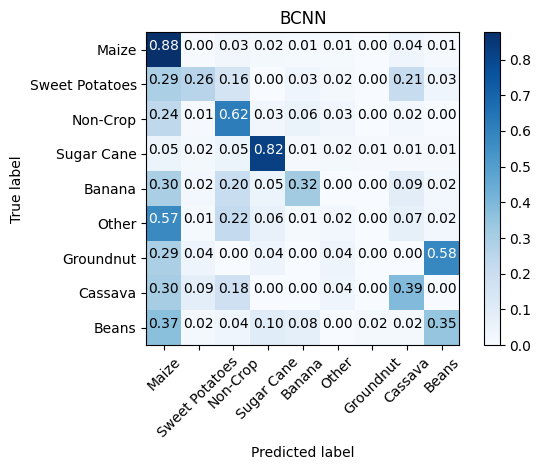

In [71]:
from sklearn.metrics import confusion_matrix
import itertools

# code to plot multi class confusion matrix from https://www.kaggle.com/code/meaninglesslives/simple-neural-net-for-time-series-classification/notebook
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

matrix = confusion_matrix(dataset[split_idx['y_test']], random_forest_stats[PREDS])
plot_confusion_matrix(matrix, CROPS, title='Random Forest (Baseline)')
matrix = confusion_matrix(dataset[split_idx['y_test']], bcnn_stats[PREDS])
plot_confusion_matrix(matrix, CROPS, title='BCNN')

As shown by the confusion matrices above, there is some bias towards classifying maize. However my best performing model (BCNN) has less of a bias than the baseline (random forest), an example of this is the the misclassification rate of beans as maize in the baseline is 0.90 whereas in the BCNN it dropped to 0.37. The previously mentioned further optimisations, that will hopefully improve performance, should also decrease this bias (as it needs to be decreased to improve performance).

## Sustainable development relevance & impact (15%)

To begin this section, I'd just like to caveat that for coursework 1 I look at the crop yield dataset from SustainBench. That dataset is closely linked to the dataset I explore here as they both aim to assist and improve agriculture to ensure food security. Therefore, they both have very similar sustainable development relevance and impact, so I will be using the some of the same arguments and references as I did in coursework 1, and I do not want to be committing self-plagiarism therefore I want to make this clear.

For convenience of not repeating myself in this section, I define the main application of the dataset and any ML model using it (I say any, not only mine, as this section is also relevant to any future improved models) as: the classifications of the model could be used to create crop type maps for middle/low-income countries, where currently these maps are not currently available, which can be used to assess agricultural diversity and estimate yields. This in turn can be used by governments and policymakers, enabling essential tasks such as allocating government resources, evaluating agricultural policies, planning aid distribution and making decisions about imports and exports of crops.

### Current challenges in terms of sustainable development and how can ML help
World hunger is a global problem, this can be clearly seen by the 2022 edition of The State of Food Security and Nutrition in the World (SOFI) UN report[11], which reports that as many as 828 million people were affected by hunger in 2021, which is actually higher than the 795 million reported in 2015[12]. Clearly government and policy makers need carry out essential tasks (defined above) to improve agriculture and tackle this, however in order to do this they need quantitative data that they can use to inform and base their decisions on. One form of the data that is needed is crop type maps. Currently for high income countries departments of agriculture produce crop type maps annually using farm surveys and satellite imagery [4]. However, for middle/low-income countries these are not regularly available, especially in the global south where there are challenges such as *"irregularly shaped fields, small fields, intercropping, sparse ground truth labels, and highly heterogeneous landscapes"*[5]. This is the challenge, and where the purpose of the dataset comes in, with an aim to classify crops in a global south lower-middle income country (Kenya which in 2021 has a GDP per capita of 2006.8 compared to the 2581.0 lower middle income value provided by the world bank [6]). 

The dataset by itself however is not useful, it would be very difficult for a human to look at multiple bands of a satellite and classify crops, and clearly this would not be scalable and costly if you wanted a crop map of multiple regions/a whole country. This is where ML can help, a potential ML solution could be trained on the limited amount of data available and then used to classify crops in a scalable and low cost way compared to manual methods.

### Connection between the application and SDGs
I believe these are the direct connections between the application and SDGs:

- **SDG 2 Zero Hunger** - as the application aims to support and improve agricultural practices, it clearly aims to help foods security and therefore the following targets of this goal are connected: **2.1** which aims to end world hunger and **2.3** which aims to double agricultural productivity. 2.3 is especially important in light of the projection that *”the total global food demand is expected to increase by 35% to 56% between 2010 and 2050”*[13], which also highlights the importance of this application.
- **SDG 12 Responsible Consumption and Production** - as the application aims to help food security, it will clearly affect the production and consumption patterns of food, in particular crops. It is clear that having crop type maps will allow more informed decisions to be made regarding food waste, and therefore the application is linked to target **12.3** which aims to halve per capita global food waste. The importance of this is shown by the 2021 edition of the UN Food Waste Index Report[14], which reports that around 931 million tonnes of food goes to waste each year.

I believe there are also some indirect connections between the application and SDGs, both positive and negative:

- **SDG 3 Good Health and Well-being** - as the application aims to help food security it could increase food production. Initially this seems purely positive to people’s health and well-being, as food insecurity has been found to be consistently negatively associated with health[15] and linked to higher odds of suicide[16]. Therefore, the application is positively linked to target **3.4** which aims to reduce premature mortality by one third and promote mental health. On the other hand how exactly this increased food production is reached could have a negative impact on health as previous industrialization of agriculture has led to an increased use of agrochemical[17], which if used incorrectly can have severe negative effects[28]. This could mean the application could have a negative effect on target **3.9** which aims to reduce the number of deaths and illnesses from hazardous chemicals.
- **SDG 6 Clean Water and Sanitation** - as the application aims to help food security it could increase the amount of agriculture. Therefore the application could have a negative impact on the availability of water as agriculture is the greatest water user globally[19]. This paired with the fact that freshwater scarcity is becoming a reality[20], could mean that the application could have a negative effect on target **6.1** which aims to achieve universal access to safe drinking water for all.
- **SDG 8 Decent Work and Economic Growth** - as the application aims to help food security it could increase food production. This could clearly create new jobs for people, however with such a demand for growth this could instead speed up the agricultural tech revolution which could mean many farm workers instead lose their jobs, an example being in the 1960's where new tomato harvesting mechanisms *"resulted in an estimated 32,000 farm workers losing their jobs and pushing hundreds of small farms out of business."*[21]. Therefore the application has both negative and positive links to target **8.5** which aims to achieve full and productive employment for all.
- **SDG 10 Reduce inequalities** - closely linked to the point above, as the application aims to help food security it could increase food production. This demand for increased food production could speed up the agricultural tech revolution, which workers fear that *"is being done without their input, and in a way that privileges farm owners, tech developers and investors without considering the consequences for workers."*[21]. Therefore, this could mean that the application could have a negative effect on target **10.1** which aims to achieve and sustain income growth of the bottom 40 per cent of the population.
- **SDG 13 Climate Action** - as the application is aimed at agriculture, it is closely linked to climate due to the inherent link between the climate and agriculture. As the application could increase food production, it could negatively effect target **13.2** which aims to integrate climate change measures into national policies. This negative effect comes from the fact that expanding agriculture is an important cause of deforestation and forest loss[22] and agriculture also releases other greenhouse gases (GHG) such as methane and nitrous oxide[23]. Therefore, there is a clash between increased food production and target 13.2.
- **SDG 15 Life on Land** - as the application aims to help food security it could increase the amount of agriculture. The type of agriculture, and its governance will decide whether the application has a negative or positive effect on target **15.5** which aims to reduce the degradation of natural habitats and halt the loss of biodiversity. On the one hand high demand agriculture has been shown to harm biodiversity[24][25], through reasons such conversion of natural ecosystems into farms[26][27]. On the other hand, there have been promising positive results of organic agriculture on biodiversity, however the same studies[28][29][30] talking about these positives, question the variability in results and the scalability of the approach.

### Challenges with the dataset and ML model
Apart from the connections to sustainability of the application as explored above, there are inherent challenges, linked to sustainability, of the dataset and model itself.

- **accessibility** - as explored in the "ethical considerations" section, there is a clear issue of accessibility with the dataset which could in turn increase inequality and therefore work against SDG 10 (which aims to reduce inequality). To address this challenge the dataset (and its associated tools) and applications should be made publicly and easily accessible, with thorough documentation.
- **model performance** - while the use of the ML models for this dataset aims to help agriculture and food production and therefore SDG 2, if the performance is not optimal, which currently without further optimisation it is, then misclassifications of crops could actually influence wrong decisions being taken by governments and policy makers which would actually make the application work against SDG 2. To address this challenge model performance needs to be improved, I present some ideas for this in the "Further room for improvement" section.
- **bias** - as explored in the "ethical considerations" section, currently there is a bias in the ML models towards classifying crops as maize, due to the class imbalance in the dataset. This again could make the application work against SDG 2 in the same way as bad model performance. To address this challenge, as above, performance of the model would need to be improved. Another way to address this would be to perform data augmentation on the dataset to try to alleviate the imbalance. However, the two common ways for this are undersampling and oversampling, which in the context of this dataset are both difficult. For undersampling, the dataset is already small, so undersampling would mean reducing an already small dataset, which would make achieving high performance using deep-learning even harder. For oversampling, oversampling is difficult in the context of timeseries classification, although many proposed oversampling methods exist, *"synthetic samples based on the oversampling methods are short of diversity or variation to fail to accurately reveal the real minority class distribution"*[31], and methods that try to address this are complex and/or computationally heavy.

## References

[1] D. M. Kluger, S. Wang, and D. B. Lobell. Two shifts for crop mapping: Leveraging aggregate crop statistics to improve satellite-based maps in new regions. Remote Sensing of Environment, 262:112488, 2021.

[2] Z. Jin, G. Azzari, C. You, S. Di Tommaso, S. Aston, M. Burke, and D. B. Lobell. Smallholder maize area and yield mapping at national scales with google earth engine.Remote Sensing of Environment, 228:115–128, 2019.

[3] C. Yeh, C. Meng, S. Wang, A. Driscoll, E. Rozi, P. Liu, J. Lee, M. Burke, D. Lobell, and S. Ermon, “SustainBench: Benchmarks for Monitoring the Sustainable Development Goals with Machine Learning,” in Thirty-fifth Conference on Neural Information Processing Systems, Datasets and Benchmarks Track (Round 2), Dec. 2021. [Online]. Available: https://openreview.net/forum?id=5HR3vCylqD.

[4] National Agricultural Statistics Service. USDA National Agricultural Statistics Service Cropland Data
Layer. Published crop-specific data layer [Online], 2018. URL https://nassgeodata.gmu.edu/
CropScape/.

[5] R. Rustowicz, R. Cheong, L. Wang, S. Ermon, M. Burke, and D. Lobell. Semantic Segmentation of
Crop Type in Africa: A Novel Dataset and Analysis of Deep Learning Methods. In Proceedings of the
IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR) Workshops, June 2019.

[6] "Data for Kenya, Lower middle income" https://data.worldbank.org/?locations=KE-XN. Accessed 11 December 2021.

[7] Yu, Y., Si, X., Hu, C. & Zhang, J. (2019), ‘A review of recurrent neural networks:
Lstm cells and network architectures’, Neural computation 31(7), 1235–1270.

[8] Gawlikowski, J., Tassi, C. R. N., Ali, M., Lee, J., Humt, M., Feng, J., Kruspe,
A., Triebel, R., Jung, P., Roscher, R. et al. (2021), ‘A survey of uncertainty
in deep neural networks’, arXiv preprint arXiv:2107.03342 .

[9] Blundell, C., Cornebise, J., Kavukcuoglu, K. & Wierstra, D. (2015), Weight un-
certainty in neural network, in ‘International conference on machine learning’,
PMLR, pp. 1613–1622.

[10] Y. Zhang, P. Tiňo, A. Leonardis and K. Tang, "A Survey on Neural Network Interpretability," in IEEE Transactions on Emerging Topics in Computational Intelligence, vol. 5, no. 5, pp. 726-742, Oct. 2021, doi: 10.1109/TETCI.2021.3100641.

[11] FAO, IFAD, UNICEF, WFP, and WHO, “The state of food security and nutrition in the world 2022,” 2022. [Online]. Available: https://doi.org/10.4060/cc0639en

[12] FAO, IFAD, and WFP, “The state of food security and nutrition in the world 2015,” 2015. [Online]. Available: https://reliefweb.int/sites/reliefweb.int/files/resources/a-i4646e.pdf

[13] M. van Dijk, T. Morley, M. L. Rau, and Y. Saghai, “A meta-analysis of projected global food demand and population at risk of hunger for the period 2010–2050,” Nature Food, vol. 2, no. 7, p. 494–501, 2021.

[14] UNEP, “Food waste index report 2021,” 2021. [Online]. Available: https://www.unep.org/resources/report/unep-food-waste-index-report-2021

[15] C. Gundersen and J. P. Ziliak, “Food insecurity and health outcomes,” Health Affairs, vol. 34, no. 11, p. 1830–1839, 2015.

[16] L. McIntyre, J. V. Williams, D. H. Lavorato, and S. Patten, “Depression and suicide ideation in late adolescence
and early adulthood are an outcome of child hunger,”
Journal of affective disorders, vol. 150, no. 1, pp. 123–
129, 2013.

[17] P. Nicolopoulou-Stamati, S. Maipas, C. Kotampasi, P. Stamatis, and L. Hens, “Chemical pesticides and human health: the urgent need for a new concept in agriculture,” Frontiers in public health, vol. 4, p. 148, 2016.

[18] F. P. Carvalho, “Agriculture, pesticides, food security and food safety,” Environmental science & policy, vol. 9, no. 7-8, pp. 685–692, 2006.

[19] F. Aquastat, “Fao’s global information system on water and agriculture,” 2020.[Online]. Available: https://www.fao.org/aquastat/en/

[20] P. H. Gleick and H. Cooley, “Freshwater scarcity,” Annual Review of Environment and Resources, vol. 46, pp. 319–348, 2021.

[21] M. Sainato, “Grapes, berries and robots: is Silicon Valley coming for farm workers jobs?” The Guardian, 2022. [Online]. Available: https://www.theguardian.com/environment/2022/sep/08/california-agriculture-technology-farm-workers

[22] M. G. Ceddia, N. O. Bardsley, S. Gomez-y Paloma, and S. Sedlacek, “Governance, agricultural intensification, and land sparing in tropical south america,” Proceedings of the National Academy of Sciences, vol. 111, no. 20, pp. 7242–7247, 2014.

[23] “Agriculture and climate change,” 2015. [Online]. Available: https://www.eea.europa.eu/signals/signals-2015/articles/agriculture-and-climate-change

[24] D. S. Wilcove and L. P. Koh, “Addressing the threats to biodiversity from oil-palm agriculture,” Biodiversity and conservation, vol. 19, no. 4, pp. 999–1007, 2010.

[25] N. Dudley and S. Alexander, “Agriculture and biodiversity: a review,” Biodiversity, vol. 18, no. 2-3, pp. 45–49, 2017.

[26] O. Dubois et al., The state of the world’s land and water resources for food and agriculture: managing systems at risk. Earthscan, 2011.

[27] H. K. Gibbs, A. S. Ruesch, F. Achard, M. K. Clayton, P. Holmgren, N. Ramankutty, and J. A. Foley, “Tropical forests were the primary sources of new agricultural land in the 1980s and 1990s,” Proceedings of the National Academy of Sciences, vol. 107, no. 38, pp. 16 732–16 737, 2010.

[28] T. Underwood, C. McCullum-Gomez, A. Harmon, and S. Roberts, “Organic agriculture supports biodiversity and sustainable food production,” Journal of Hunger & Environmental Nutrition, vol. 6, no. 4, pp. 398–423, 2011.

[29] J. Bengtsson, J. Ahnstrom, and A.-C. WEIBULL, “The ¨
effects of organic agriculture on biodiversity and abundance: a meta-analysis,” Journal of applied ecology, vol. 42, no. 2, pp. 261–269, 2005.

[30] V. Seufert and N. Ramankutty, “Many shades of gray—the context-dependent performance of organic agriculture,” Science advances, vol. 3, no. 3, p. e1602638, 2017.

[31] Liu, C., Wang, X., Wu, K., Tan, J., Li, F. and Liu, W., 2018, December. Oversampling for imbalanced time series classification based on generative adversarial networks. In 2018 IEEE 4th International Conference on Computer and Communications (ICCC) (pp. 1104-1108). IEEE.